In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from astropy.stats import biweight_location
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry

# default Gratama gain and readnoise
gain=1.4
rn=13.

# make the plots BIG
plt.rcParams['figure.figsize'] = [10,10]

# Standard Star Fields

We need to calibrate our data. The first step is to photometer our standard star images and then compare these measurements to the Landolt standard star data.

In the following, I concentrate on inferring the B and V calibrations without corrections for atmospheric extinction (the airmass term). With some close reading, this notebook can be extended to cover R (and even I) band calibrations and atmospheric extinction.

In [29]:
# read in the Landolt standard star data
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack

landolt=Table.read('landolt_all.csv',format='ascii.csv')
landolt

Name,RA,DEC,V,B-V,U-B,V-R,R-I,V-I,Nobs,Nn,e_V,e_B-V,e_U-B,e_V-R,e_R-I,e_V-I
str12,str12,str12,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
TPhe I,00:30:04.593,-46:28:10.17,14.82,0.764,0.338,0.422,0.395,0.817,25,13,0.0026,0.0032,0.0072,0.0036,0.0098,0.011
TPhe A,00:30:09.594,-46:31:28.91,14.651,0.793,0.38,0.435,0.405,0.841,29,12,0.0028,0.0046,0.0071,0.0019,0.0035,0.0032
TPhe H,00:30:09.683,-46:27:24.30,14.942,0.74,0.225,0.425,0.425,0.851,23,12,0.0029,0.0029,0.0071,0.0035,0.0077,0.0098
TPhe B,00:30:16.313,-46:27:58.57,12.334,0.405,0.156,0.262,0.271,0.535,29,17,0.0115,0.0026,0.0039,0.002,0.0019,0.0035
TPhe C,00:30:16.980,-46:32:21.40,14.376,-0.298,-1.217,-0.148,-0.211,-0.36,39,23,0.0022,0.0024,0.0043,0.0038,0.0133,0.0149
TPhe D,00:30:18.342,-46:31:19.85,13.118,1.551,1.871,0.849,0.81,1.663,37,23,0.0033,0.003,0.0118,0.0015,0.0023,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA 41-179,21:54:10.448,+45:16:31.11,11.868,0.498,0.177,0.291,0.296,0.586,9,4,0.0017,0.0014,0.0029,0.0011,0.0019,0.0004
SA 41-182,21:54:12.587,+45:14:36.50,9.969,0.307,0.159,0.182,0.197,0.381,15,8,0.0009,0.0011,0.0007,0.0006,0.001,0.0012


In [30]:
# set up the positions for photometry
positions_landolt = SkyCoord(landolt['RA'], landolt['DEC'], unit=(u.hourangle, u.deg), frame='icrs')
#positions

Now we need to read in our images. THese images __must__ be fully processed (e.g., bias-, dark-, and flat field-corrected) __and__ must have a world-coordinate system (WCS) (from, e.g., astrometry.net: [link](http:://astrometry.net)) __and__ airmasses in their headers.

In [ ]:
import glob
fnames=glob.glob('./OAprocessed*Coord*-wcs.fits')
fnames.sort()

In [35]:
# do the photometry

phot_tables={}
filters=[]
airmass=[]
for f in fnames:
    with fits.open(f) as hdu:
        # get filter and airmass
        filters.append(hdu[0].header['FILTER'])
        airmass.append(hdu[0].header['AIRMASS'])
        exptime = hdu[0].header['EXPTIME']
        imshape = hdu[0].data.shape
        # determine the sky position of the image center
        wcs = WCS(hdu[0].header)
        sky_imcenter = wcs.pixel_to_world(imshape[0]/2,imshape[1]/2)

        print('frame: {} exptime: {} filter: {} airmass: {} image center: {}'.format(f,exptime,filters[-1],airmass[-1],sky_imcenter))

        #select the proper landolt stars
        sep=positions_landolt.separation(sky_imcenter)
        positions=positions_landolt[sep<1.*u.deg]
        names=landolt['Name'][sep<1.*u.deg]
        V=landolt['V'][sep<1.*u.deg]
        BmV=landolt['B-V'][sep<1.*u.deg]
        VmR=landolt['V-R'][sep<1.*u.deg]
        Nobs=landolt['Nobs'][sep<1.*u.deg]

        # read frame and compute noise
        fd = hdu[0].data * gain * exptime
        fd2 = np.where(np.greater(fd, 0.), fd, 0.)
        fderr = np.sqrt(fd2 + rn**2)
        
        # remove background
        bkg_estimator = BiweightLocationBackground()
        bkg = Background2D(fd, (50,50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
        fdnobkg = fd-bkg.background

        # landolt photometry assumes 14" (diameter) apertures
        aperture = SkyCircularAperture(positions, r=7.*u.arcsec)

        # get WCS
        wcs = WCS(hdu[0].header)
        # convert apertures to pixels
        pix_aperture = aperture.to_pixel(wcs)
        
        # do the photometry
        phot_table = aperture_photometry(fdnobkg, pix_aperture, error=fderr)
        
        # convert to magnitudes
        apsum = ma.masked_less_equal(phot_table['aperture_sum'],0.)
        phot_table['m{}'.format(filters[-1])] = -2.5*ma.log10(apsum) + 2.5*log10(exptime)
        aperr = ma.masked_less_equal(phot_table['aperture_sum_err'],0.)
        phot_table['e{}'.format(filters[-1])] = 2.5*log10(exp(1.))*aperr/apsum
        # add the airmass to the output table
        phot_table['Airmass'] = airmass[-1]*np.ones(phot_table['aperture_sum'].shape)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'
        
        # add star names and Landolt photometry to the output table
        phot_table['Name'] = names
        phot_table['V'] = V
        phot_table['B-V'] = BmV
        phot_table['V-R'] = VmR
        phot_table['Nobs'] = Nobs
        try:
            phot_tables[filters[-1]]=vstack([phot_tables[filters[-1]],phot_table])
        except:
            phot_tables[filters[-1]]=phot_table
        # print(phot_tables[filters[-1]])

frame: ./OAprocessed_220515_Li_.00000031.Entered_Coordinates-wcs.fits exptime: 60.0 filter: V airmass: 1.014477388252 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.26101396, 43.90151544)>


frame: ./OAprocessed_220515_Li_.00000032.Entered_Coordinates-wcs.fits exptime: 60.0 filter: R airmass: 1.014278393311 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.26140897, 43.9016745)>


frame: ./OAprocessed_220515_Li_.00000033.Entered_Coordinates-wcs.fits exptime: 60.0 filter: B airmass: 1.014104115413 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.26127805, 43.90156814)>


frame: ./OAprocessed_220515_Li_.00000034.Entered_Coordinates-wcs.fits exptime: 60.0 filter: V airmass: 1.013941418107 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.2621659, 43.90181369)>


frame: ./OAprocessed_220515_Li_.00000035.Entered_Coordinates-wcs.fits exptime: 60.0 filter: B airmass: 1.013780348223 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.26310432, 43.90172956)>


frame: ./OAprocessed_220515_Li_.00000036.Entered_Coordinates-wcs.fits exptime: 60.0 filter: R airmass: 1.013675116627 image center: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (194.26446086, 43.90218468)>


In [36]:
#phot_tables['R'].show_in_notebook()

In [37]:
from numpy.linalg import svd

# least-squares fitting using singular value decomposition
def svdfit2(b,y,sigma):
    b=b/sigma[:,np.newaxis]
    y=y/sigma
    ndeg=len(y)-b.shape[1]
    u,w,v=svd(b, full_matrices=False)
    s1=np.transpose(v)
    s2=ma.divide(1.,w)
    #print(s2)
    s3=np.dot(np.transpose(u),y)
    #print(s3.shape)
    if any(s3):
        sr=(s2*s3)
        sol=np.dot(s1,sr)
    else:
        sol=np.zeros(s3.shape)
    var=np.where(np.not_equal(w,0.),np.sum(np.power(v/w[:,np.newaxis],2),1),0.)
    chi2=np.sum(np.power(y-np.sum(b*sol[np.newaxis,:],1),2))
    return sol,var,chi2/ndeg

Now we fit the data to produce the calibrations to give magnitude differences from the "true" (Landolt) magnitudes in terms of color (and airmass, if the range is large enough).

delta V =  20.551 +/-   0.001 +  -0.050 +/-   0.005 color


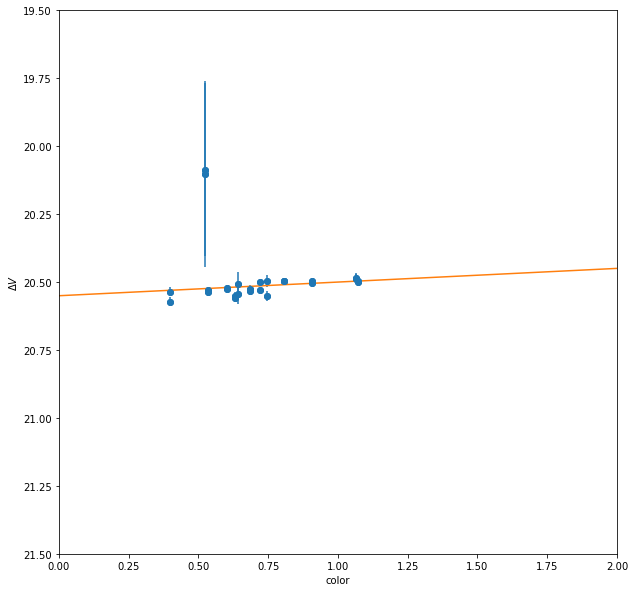

delta R =  20.811 +/-   0.000 +  -0.095 +/-   0.007 color


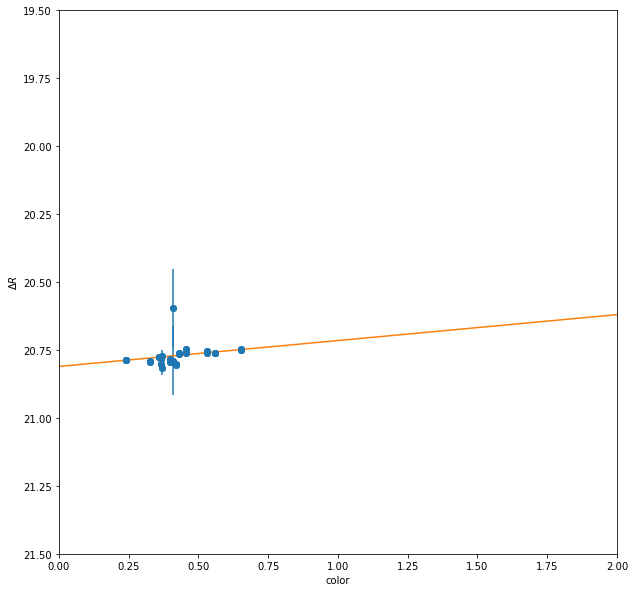

delta B =  20.208 +/-   0.001 +   0.200 +/-   0.010 color


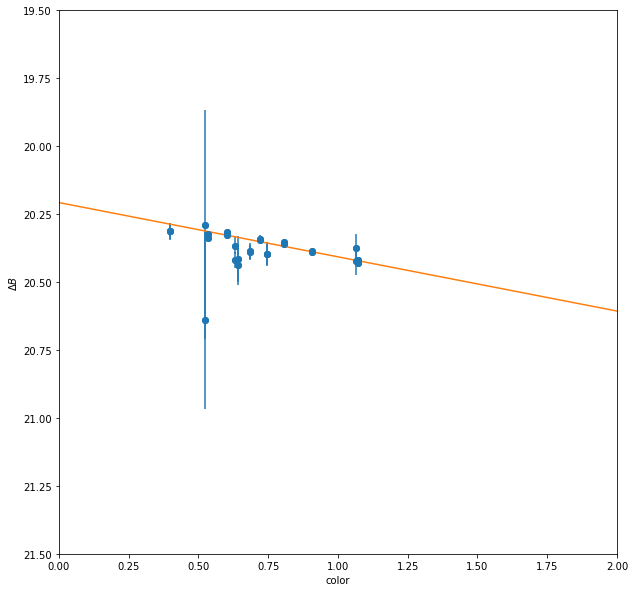

In [38]:
sols={}
for filt in phot_tables.keys():
    mask = np.logical_not(phot_tables[filt]['m{}'.format(filt)].mask) & np.greater(phot_tables[filt]['Nobs'],1)
    if filt == 'V':
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']))
        magdiff = (phot_tables[filt]['V']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['B-V']))
    elif filt == 'B':
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']+phot_tables[filt]['B-V']))
        magdiff = (phot_tables[filt]['V']+phot_tables[filt]['B-V']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['B-V']))
    else: #filt == 'R'
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']-phot_tables[filt]['V-R']))
        magdiff = (phot_tables[filt]['V']-phot_tables[filt]['V-R']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['V-R']))
    sigma = phot_tables[filt]['e{}'.format(filt)].compressed()
    airmass = np.array(np.compress(mask, phot_tables[filt]['Airmass']))
    aircolor = color * airmass
    #print(filt,magdiff,magtrue,color,sigma,airmass,aircolor)
    
    # do the fitting
    y=magdiff
    basis=[]
    basis.append(np.ones(y.shape))
    basis.append(color)
    ## if you have enough data to measure the extinction corrections, uncomment the following two lines
    ## in that case, the sol and var arrays will have four entries, not two, and the inversion below requries a matrix inverstion
    #basis.append(airmass)
    #basis.append(aircolor)
    basis=np.transpose(np.array(basis))
    sol,var,chi2 = svdfit2(basis,y,sigma)
    #print(filt,sol,np.sqrt(var),chi2)
    print('delta {} = {:7.3f} +/- {:7.3f} + {:7.3f} +/- {:7.3f} color'.format(filt,sol[0],np.sqrt(var)[0],sol[1],np.sqrt(var)[1]))
    sols[filt]=sol
    
    # plot the fit result
    fig, ax = plt.subplots()
    ax.scatter(color,magdiff)
    ax.set(xlim=(0.,2.),ylim=(21.5,19.5))
    ax.errorbar(color, magdiff, yerr=sigma, fmt='o')
    ax.set_xlabel(r'color')
    ax.set_ylabel(r'$\Delta {}$'.format(filt))
    x=np.arange(0,2.1,0.1)
    y=sol[0]+x*sol[1]
    ax.plot(x, y)
    plt.show()



# Apply the calibration

The calibrations are given in the form $$X_{true}-X_{instrumental} = a_0 + a_1 \times (X-Y)_{true}\\ Y_{true}-Y_{instrumental} = b_0 + b_1 \times (X-Y)_{true},$$ so they need to be inverted to solve for $X_{true}$ (and $(X-Y)_{true}$) in terms of $X_{instrumental}$ and $(X-Y)_{instrumental}$.

Here we assume that the $B$- and $V$-band photometry results are stored in astropy.Table tables called photB and photV, respectively.

In [32]:
# invert the solutions from true mags to observed mags and the solve for the true mags
a0=sols['B'][0] ; a1=sols['B'][1]
b0=sols['V'][0] ; b1=sols['V'][1]
#print(a0,a1,b0,b1)

BmVtrue = (photB['B-V'] + a0-b0)/(1-a1+b1)
Btrue = photB['magnitude'] + a0 + a1*BmVtrue
Vtrue = photV['magnitude'] + b0 + b1*BmVtrue

#print(BmVtrue, Btrue, Vtrue)

/Users/sctrager/Python/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


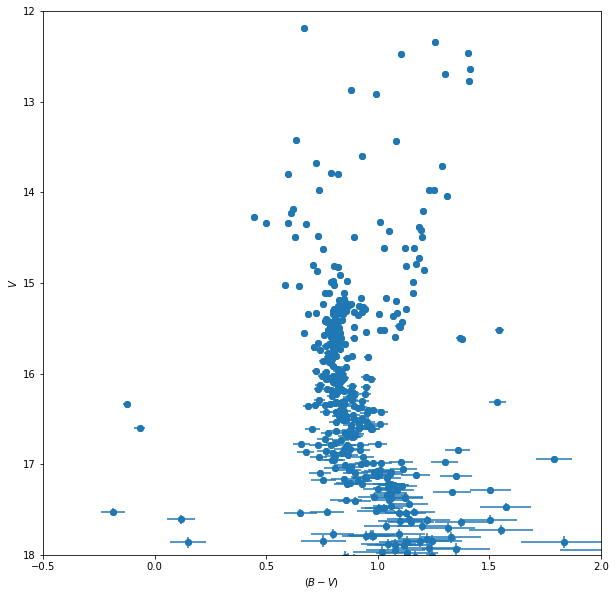

In [33]:
# plot that sucker!
fig, ax = plt.subplots()
ax.scatter(BmVtrue, Vtrue)
ax.set(xlim=(-0.5,2.),ylim=(18, 12))
ax.errorbar(BmVtrue, Vtrue, xerr=photV['eB-V'], yerr=photV['magerr'], fmt='o')
ax.set_xlabel(r'$(B-V)$')
ax.set_ylabel(r'$V$')
#plt.show()
plt.savefig('G04_cmd_calibrated.pdf')